# Fitting Linear and Non-Linear Models to solve the German credit risk scoring classification problem

#### Let's import the support libraries developed manually for this project and load the original dataset

In [31]:
%matplotlib inline
from classifiers import *
from dim_red import *

Loading German Credit scoring dataset transformed to use comma-separated values and printing numpy array dimensions

In [32]:

[X,y] = load_dataset('new-german-data.numeric',delim=',')
print X.shape
print y.shape

(999, 24)
(999,)


#### In order to take a first glance of the distribution of data, the first two principal components are calculated from the original data using PCA and plotted in 2D. It can be observed how there are certain spaces where data points of an specific class appear together, however there is no clear separation devisable through PCA analysis.

[ 0.08670779  0.02257107]


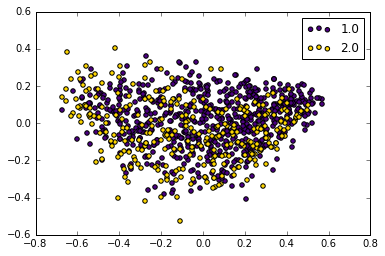

In [33]:
pca = PCA(n_components=2)
pca.fit(X,y)
print pca.explained_variance_
plotPCA(X,y)

#### In order to understand the relevance of the features of the dataset wrapper methods will be use to see the influence of the features on the final output. First the dataset will be splitted two obtain a training and test set, and then a simple SVM Linear classifier will be built in order to have a first glance on the influence of each attribute.

In [34]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=10, probability=True)

In [35]:
def feature_analysis_prec(X,y,clf):
    scores = []
    names = range(0,X.shape[1])
    for i in range(X.shape[1]):
         score = cross_val_score(clf, X[:, i:i+1], y, scoring="precision",
                                  cv=ShuffleSplit(len(X), 3, .3))
         scores.append((round(np.mean(score), 3), names[i]))
    sorted_scores = sorted(scores, reverse=True)
    print sorted_scores
    return sorted_scores[0:4]
    
ss = feature_analysis_prec(X,y,clf)


[(0.721, 23), (0.72, 21), (0.717, 5), (0.716, 8), (0.713, 19), (0.712, 14), (0.71, 18), (0.71, 2), (0.709, 17), (0.706, 16), (0.704, 9), (0.703, 6), (0.701, 3), (0.699, 15), (0.697, 20), (0.697, 11), (0.696, 13), (0.694, 22), (0.693, 7), (0.693, 4), (0.693, 1), (0.689, 10), (0.683, 12), (0.683, 0)]


It can be seen that most of the features has a level of relevance regarding the precision of the classifier; which works as an indication of the false positive rate, critical for credit scoring. To take an additional glance to the ability of the features to represent the outcome let's take the first 4 higher relevant features and calculate and plot PCA on them. 

[ 0.00102206  0.00042843]


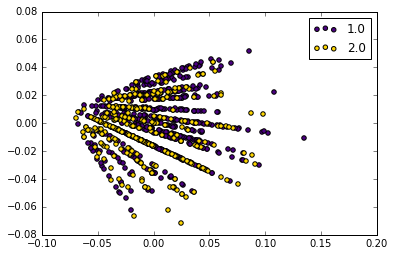

In [36]:
X_r = X[:,[ss[0][1],ss[1][1],ss[2][1],ss[3][1]]]
pca = PCA(n_components=2)
pca.fit(X_r,y)
print pca.explained_variance_
plotPCA(X_r,y)

As expected, no much better representational ability is obtained from the principal components on the first 4 most relevant features since each of the features is adding a certain degree of value on predicting the final outcome.

#### Given the complexity of the feature space more sophisticated models must be built in order to represent more accurately the nature of the data. In the following sections three different models are built using a Linear SVM, RBF Kernel SVM and Random Decision Forests. The latest two are expected to give better prediction rates (in terms of f1 measure, a ratio of precision and recall) at the expense of higher risk of overfitting. In order to avoid this a grid search is performed on each method to obtain the better model in terms of test set fitting accuracy, and cross validation is performed on each parameter combination to obtain a more representative mean accuracy in each case.

### Linear SVM

Let's split the dataset into 70% training set and 30% test set. Then less obtain the best model through cross validated grid search

In [37]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

param_grid = [
  {'C': [0.01,0.1, 1, 10, 100,1000], 'kernel': ['linear']}
 ]

clf = svm.SVC(kernel='linear', C=10)
clf = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
clf.fit(X_train, y_train)

print("Best parameters combination")
print(clf.best_params_)
print("F1 scores on each combination:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters combination
{'kernel': 'linear', 'C': 100}
F1 scores on each combination:
0.816 (+/-0.002) for {'kernel': 'linear', 'C': 0.01}
0.816 (+/-0.002) for {'kernel': 'linear', 'C': 0.1}
0.816 (+/-0.002) for {'kernel': 'linear', 'C': 1}
0.816 (+/-0.002) for {'kernel': 'linear', 'C': 10}
0.826 (+/-0.021) for {'kernel': 'linear', 'C': 100}
0.823 (+/-0.029) for {'kernel': 'linear', 'C': 1000}
Detailed classification report:
             precision    recall  f1-score   support

        1.0       0.84      0.91      0.87       217
        2.0       0.70      0.53      0.60        83

avg / total       0.80      0.81      0.80       300



Plotting the confusion matrix on the results we obtain the following:

[[198  19]
 [ 39  44]]
[[ 0.66        0.06333333]
 [ 0.13        0.14666667]]
Good Accepted + Bad Rejected: 0.81 
Bad Accepted + Good Rejected: 0.19 
Associated cost: 239.00


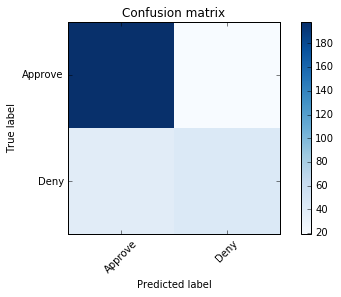

In [38]:
from sklearn.metrics import confusion_matrix
from __future__ import division

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,['Approve','Deny'])

# brute confusion matrix values
print cm
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

# percentual confusion matrix values
total = cm.sum()
print cm / total
print("Good Accepted + Bad Rejected: %0.2f "% ((cm[0,0]+cm[1,1])/total))
print("Bad Accepted + Good Rejected: %0.2f "% ((cm[0,1]+cm[1,0])/total))

# storing linear SVM results
lsvm_cm = cm

# Associated cost - from cost matrix
cost = (TN*1) + (FP*5)
print "Associated cost: %0.2f" % cost

### RBF Kernel SVM

Given the complexity of the feature space, evidenced in the initial plots, it is expected that a more sophisticated transformation of the feature space, such as the nonlinear transformation attempted by RBF Kernel SVM, would allow a better fit. We will reuse the same training/test splitting performed before in order to guarantee consistency. Again the best model will be obtained a cross validated grid search.

In [39]:
from sklearn.metrics import classification_report
from sklearn.lda import LDA


param_grid = [
  {'C': [0.01,0.1, 1, 10, 100,1000], 'kernel': ['rbf'], 'gamma' : [0.01,0.1,1,10,100,1000]}
 ]

clf = svm.SVC(kernel='rbf', C=10, gamma = 1)
clf = GridSearchCV(clf, param_grid, cv=5, scoring='f1')

clf.fit(X_train, y_train)

print("Best parameters combination")
print(clf.best_params_)
print("F1 scores on each combination:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters combination
{'kernel': 'rbf', 'C': 100, 'gamma': 1}
F1 scores on each combination:
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.1}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 1}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 10}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 100}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 1000}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 10}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 100}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 1000}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
0.816 (+/-0.002) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.816 (+/-0.002) f

Plotting the confusion matrix on the results we obtain the following:

[[194  23]
 [ 27  56]]
[[ 0.64666667  0.07666667]
 [ 0.09        0.18666667]]
Good Accepted + Bad Rejected: 0.83 
Bad Accepted + Good Rejected: 0.17 
Associated cost: 191.00


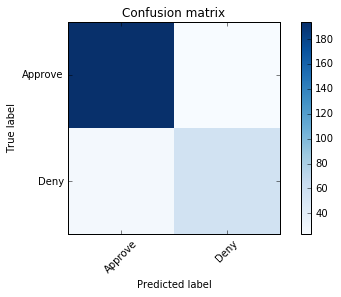

In [40]:
from sklearn.metrics import confusion_matrix
from __future__ import division

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,['Approve','Deny'])

# brute confusion matrix values
print cm
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

# percentual confusion matrix values
total = cm.sum()
print cm / total
print("Good Accepted + Bad Rejected: %0.2f "% ((cm[0,0]+cm[1,1])/total))
print("Bad Accepted + Good Rejected: %0.2f "% ((cm[0,1]+cm[1,0])/total))

# storing RBF Kernel SVM results
rbfsvm_cm = cm

# Associated cost - from cost matrix
cost = (TN*1) + (FP*5)
print "Associated cost: %0.2f" % cost

### Random Decision Forests

This bagging algorithm produces and ensemble of decision trees, capable to fit very complex feature spaces. RDF's have proven to be consistently accurate in wider ranges of problems. Since a sufficiently long trees within the ensembles are capable to fit any particular space, a high risk of overfitting arises, so its necessary to perform a thorough search in the parameters space. The same procedure as before is followed.

In [41]:
from sklearn.metrics import classification_report
from scipy.stats import randint as sp_randint

param_grid = [{"max_depth": [3, 5,10,15,20,30,40,70],
               "max_features": [1, 3, 10,15,20]
              }
             ]

clf = RandomForestClassifier(max_features = 'auto', max_depth=10)
clf = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
clf.fit(X_train, y_train)

print("Best parameters combination")
print(clf.best_params_)
print("F1 scores on each combination:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

# Please wait, this could take a while

Best parameters combination
{'max_features': 3, 'max_depth': 30}
F1 scores on each combination:
0.820 (+/-0.041) for {'max_features': 1, 'max_depth': 3}
0.823 (+/-0.032) for {'max_features': 3, 'max_depth': 3}
0.824 (+/-0.028) for {'max_features': 10, 'max_depth': 3}
0.825 (+/-0.031) for {'max_features': 15, 'max_depth': 3}
0.824 (+/-0.026) for {'max_features': 20, 'max_depth': 3}
0.816 (+/-0.040) for {'max_features': 1, 'max_depth': 5}
0.827 (+/-0.028) for {'max_features': 3, 'max_depth': 5}
0.820 (+/-0.044) for {'max_features': 10, 'max_depth': 5}
0.809 (+/-0.032) for {'max_features': 15, 'max_depth': 5}
0.828 (+/-0.022) for {'max_features': 20, 'max_depth': 5}
0.805 (+/-0.021) for {'max_features': 1, 'max_depth': 10}
0.811 (+/-0.037) for {'max_features': 3, 'max_depth': 10}
0.799 (+/-0.041) for {'max_features': 10, 'max_depth': 10}
0.812 (+/-0.021) for {'max_features': 15, 'max_depth': 10}
0.793 (+/-0.036) for {'max_features': 20, 'max_depth': 10}
0.810 (+/-0.023) for {'max_features

[[192  25]
 [ 47  36]]
[[ 0.64        0.08333333]
 [ 0.15666667  0.12      ]]
Good Accepted + Bad Rejected: 0.76 
Bad Accepted + Good Rejected: 0.24 
Associated cost: 271.00


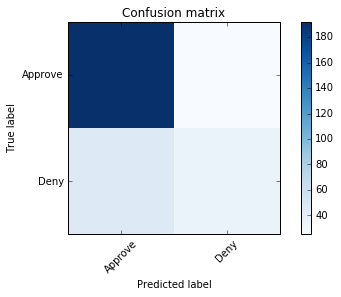

In [43]:
from sklearn.metrics import confusion_matrix
from __future__ import division

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,['Approve','Deny'])

# brute confusion matrix values
print cm
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

# percentual confusion matrix values
total = cm.sum()
print cm / total
print("Good Accepted + Bad Rejected: %0.2f "% ((cm[0,0]+cm[1,1])/total))
print("Bad Accepted + Good Rejected: %0.2f "% ((cm[0,1]+cm[1,0])/total))

# storing RDF results
rdf_cm = cm

# Associated cost - from cost matrix
cost = (TN*1) + (FP*5)
print "Associated cost: %0.2f" % cost

### Results Summary

The following graph presents the results comparison between the best models of the three presented approaches. The comparison is performed directly on the ability of discerning of a credit should be assigned or rejected, and the feasibility of a wrongly conceded credit which is a critical issue for this problem.

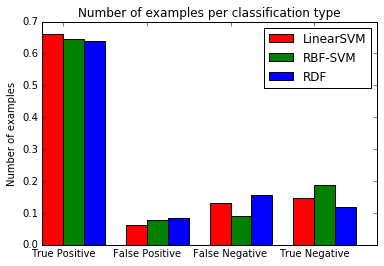

In [46]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
svm_linear = (lsvm_cm[0,0],lsvm_cm[0,1],lsvm_cm[1,0],lsvm_cm[1,1])
rbfsvm = (rbfsvm_cm[0,0],rbfsvm_cm[0,1],rbfsvm_cm[1,0],rbfsvm_cm[1,1])
rdf = (rdf_cm[0,0],rdf_cm[0,1],rdf_cm[1,0],rdf_cm[1,1])

ind = np.arange(N)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, svm_linear, width, color='r')
rects2 = ax.bar(ind+width, rbfsvm, width, color='g')
rects3 = ax.bar(ind+(width*2), rdf, width, color='b')

# add some
ax.set_ylabel('Number of examples')
ax.set_title('Number of examples per classification type')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('True Positive', 'False Positive', 'False Negative', 'True Negative') )

ax.legend( (rects1[0], rects2[0],rects3[0]), ('LinearSVM', 'RBF-SVM','RDF') )

plt.show()

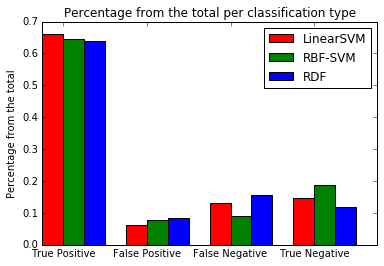

In [47]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
total = lsvm_cm.sum()
lsvm_cm = lsvm_cm/total
rbfsvm_cm = rbfsvm_cm/total
rdf_cm = rdf_cm/total

svm_linear = (lsvm_cm[0,0],lsvm_cm[0,1],lsvm_cm[1,0],lsvm_cm[1,1])
rbfsvm = (rbfsvm_cm[0,0],rbfsvm_cm[0,1],rbfsvm_cm[1,0],rbfsvm_cm[1,1])
rdf = (rdf_cm[0,0],rdf_cm[0,1],rdf_cm[1,0],rdf_cm[1,1])

ind = np.arange(N)    # the x locations for the groups
width = 0.25       # the width of the bars: can also be len(x) sequence

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, svm_linear, width, color='r')
rects2 = ax.bar(ind+width, rbfsvm, width, color='g')
rects3 = ax.bar(ind+(width*2), rdf, width, color='b')

# add some
ax.set_ylabel('Percentage from the total')
ax.set_title('Percentage from the total per classification type')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('True Positive', 'False Positive', 'False Negative', 'True Negative') )

ax.legend( (rects1[0], rects2[0],rects3[0]), ('LinearSVM', 'RBF-SVM','RDF') )

plt.show()